## PS2 Part 3: RNN

In this part we are going to implement a simple time-series prediction using RNN on a noisy simulated funcitonal data.

There are two main goals in time series prediction:

**Understanding the data:** This involves identifying the patterns and trends that exist in the data over time.    
By understanding these patterns, we can gain insights into the underlying processes that generate the data.    
For instance, time series analysis might reveal seasonal trends in sales data or cyclical patterns in stock prices.

**Forecasting future values:** This is the more commonly recognized goal of time series prediction.   
By leveraging the patterns and trends identified in the data, we can make predictions about what the data will look like in the future.   
This can be helpful for tasks like planning inventory levels, managing financial risk, or predicting weather patterns.

**Recurrent Neural Networks (RNNs)** are a powerful tool for time series prediction because they can handle the sequential nature of time series data.   Unlike traditional neural networks, RNNs have internal memory that allows them to consider past information when making predictions. This is particularly useful for time series data where the value at any given point in time is often influenced by past values.

*Here's a breakdown of how RNNs are used for time series prediction:*

The Model Architecture:

* A typical RNN model for time series prediction consists of an input layer, one or more hidden layers with special RNN cells (like LSTM or GRU), and an output layer.
The hidden layers process the data sequences.   
* Each cell in the hidden layer receives the current input and the output from the previous cell in the sequence. This allows the network to consider past information.

**The Training Process:**

* The RNN is trained on historical time series data. The model is presented with sequences of data points, and it learns to predict the next value in the sequence.  
* During training, the RNN uses backpropagation through time (BPTT), a variant of the standard backpropagation algorithm, to adjust its internal parameters and improve its prediction accuracy.

### Simulating data



> In this example, each training step ($t$) consists of a sequence of target data of length $k$ ($t-k:t$), and a training sequence of the same length, but with a lag ($t-k-l:t-l$). Our RNN should predict the target sequence using the lagged training sequence.



We simulate cyclical data using a function of `sin` and `cos`:

*   As is, the output of our function is cyclical (recurring) in `t`.
*   We also add a `sin` shift (`np.sin(s)`) that adds a small drift between steps.
* Our target is defined as: $y(t,s) = sin(sin(s)*2*\pi*t+\pi/6)+cos(2*\sqrt(3)*t) $
*   Our training data (without lag) is defined as:



$$y_{\alpha}(t,s) = sin(sin(s)*2*\pi*t+\pi/6)+cos(2*\sqrt(3)*t) + N(0,1)*\alpha$$

Image that we only observe the noisy training data and the target, without having any insight into the generating function.

P3Q1 (10pts)  
Fill out the missing code according to the function definition above

In [4]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

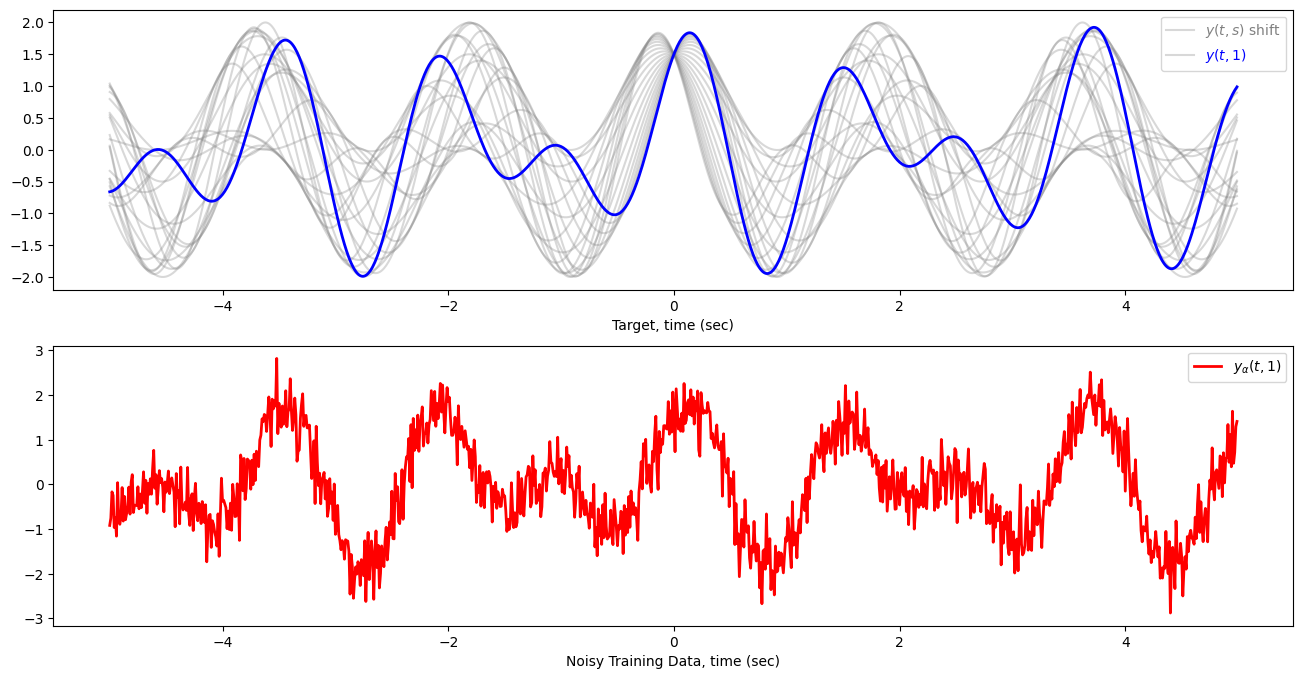

In [5]:
## SOLUTION REQUIRED IN THIS BLOCK ##

## Plotting simulated functional data

t_line = np.arange(-5., 5., 1/100.) # line space
alpha = 0.4
## Creating a function to produce cyclical y data.

y_func = lambda s: np.sin(np.sin(s) * 2 * np.pi * t_line + np.pi / 6) + np.cos(2 * t_line * np.sqrt(3))
y = y_func(1)
## Adding noise
y_noisy = y + alpha * np.random.normal(0,1, size=len(t_line)) ## SOLUTION REQURIED HERE ##


## Plotting
fig, ax = plt.subplots(2,1, figsize=(16,8))
fval = np.arange(-1,1,0.1)

for i in fval:
    ax[0].plot(t_line, y_func(i), color='gray', alpha=.3,label="$sin(f)$ shift")

ax[0].plot(t_line, y, lw = 2,label = "fixed $f$",color="b")
ax[0].set_xlabel('Target, time (sec)')
ax[1].plot(t_line, y_noisy, lw = 2,c="r")
ax[1].set_xlabel('Noisy Training Data, time (sec)')
ax[0].legend(["$y(t,s)$ shift","$y(t,1)$"],labelcolor=["gray","b"])
ax[1].legend(["$y_{\\alpha}(t,1)$"])


In the figure above we can see the true output of the generating function, given a specific value of $s$ (blue), and various drifts according to different values of $s$ (gray).  In the bottom plot you can see the noisy data (training),  matching the blue graph in the top plot.

### Creating PyTorch RNN model

Here we create a basic PyTorch RNN class (inherits from `nn.Module`).  

* *input_size* – The number of expected features (dimensions) in the input t

* *hidden_size* – The number of features in the hidden state h

* *num_layers* – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results.    

* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states.




For more information, please check the
[PyTorch nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) documentation.


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # Adding a fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden


In [7]:

# RNN Hyperparameters
input_size=1 # our data is 1-dim
output_size=1
hidden_dim=16
n_layers=2

# instantiate an RNN model
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


### RNN Training

Now we need to define a training function that takes the following hyper-parameters:  

* rnn : the RNN model object
* n_steps = on how many steps ($t$) to train the model (equivalent to "epochs").
* lag = the steps/datapoints lag between the training and target data.
* alpha = how much noise to add to the training data
* seq_length = how many datapoints  (time-series steps) to consider in each "epoch": $(t-k:t)$
* stride = the window size of the function (of which the seq_length will be divided).
* print_every = how often (in steps) to print a plot of the prediction against the target.

At each step, we have a lagged value of x, noisy lagged value of x (training), and a value of y (target not lagged).

P3Q2:  (5pts)

Fill out the missing code according to the function definition above

In [8]:
## SOLUTION REQUIRED IN THIS BLOCK##

# As above, creating a simulated data generator from our function (not noisy)
# this time, the function should depend on "step" as well (x_line is ever changing).

y_func = lambda s, t: (np.sin(np.sin(s) * 2 * np.pi * t + np.pi / 6) + np.cos(2 * np.sqrt(3) * t))


In [9]:
# train the RNN
def train(rnn,y_func, n_steps, print_every,stride,seq_length,
          alpha,lag):
    # initialize the RNN hidden state
    hidden = None
    s = 1 # initialize f
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data

        # t_line = np.linspace(y_func(s,step),y_func(s,step)+stride,seq_length+stride)
        t_line =  np.linspace(step,step+stride, seq_length)
        data = y_func(s,t_line)
        noisy_data =  data + np.random.randn(len(t_line))*alpha
        # update f
        s += 0.05

        # prepare data for training
        data.resize((seq_length , 1)) # input_size=1
        noisy_data.resize((seq_length , 1)) # input_size=1
        # creating a lag in the noisy data aginst y
        x = noisy_data[:-lag]
        y = data[lag:]

        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero out gradients
        optimizer.zero_grad()
        # calculate backprop and update weights
        loss.backward()
        optimizer.step()

        # plot loss and predictions
        if batch_i%print_every == 0:
            plt.plot(t_line[lag:], x, 'r.',label = "training")
            plt.plot(t_line[lag:], y, 'b.',label = "actual")
            plt.plot(t_line[lag:], prediction.data.numpy().flatten(), 'y.',label= "prediction") #
            plt.title("Loss: {:,}".format(loss.item()))
            plt.legend(loc="upper left")
            plt.show()

    return rnn

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

    
Train the RNN model on various hyper-parameters (defined below) and review the results.   


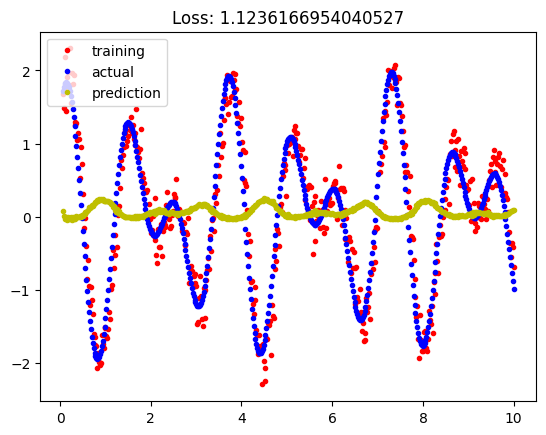

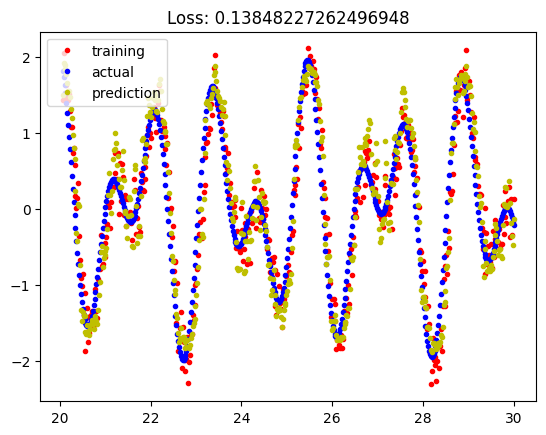

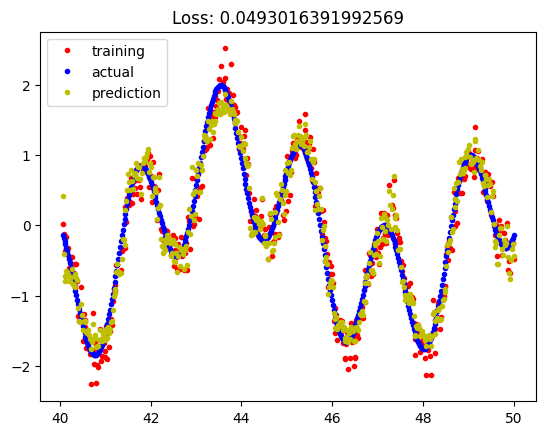

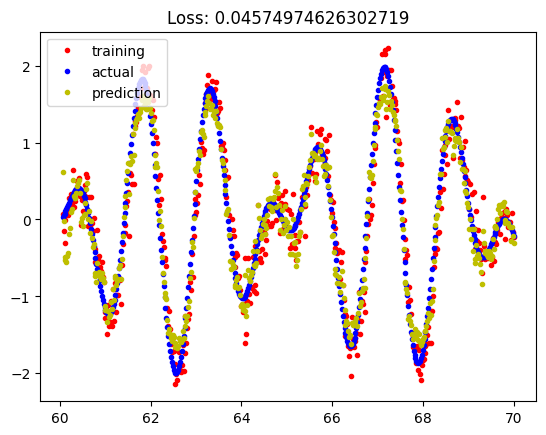

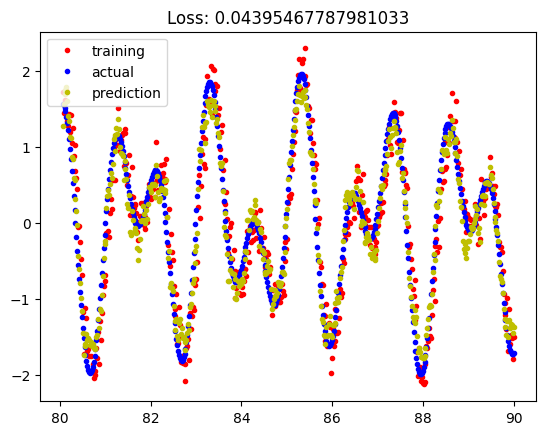

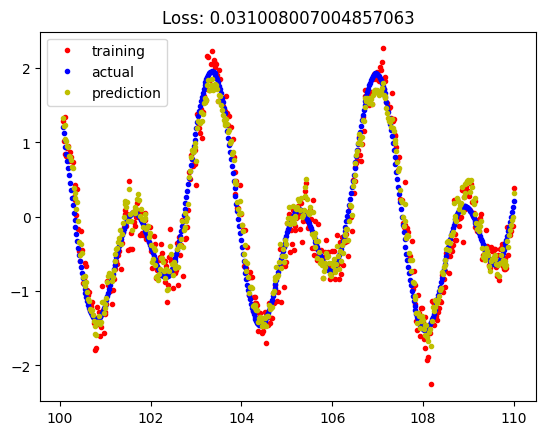

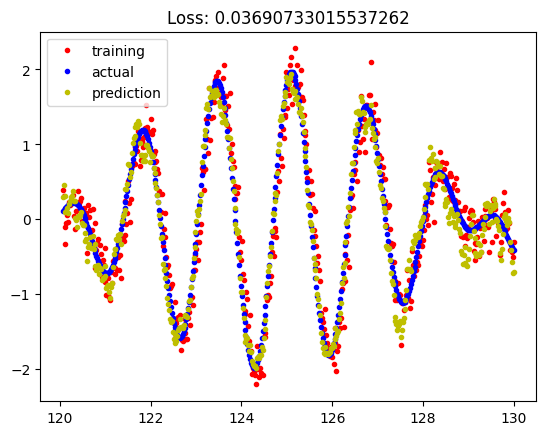

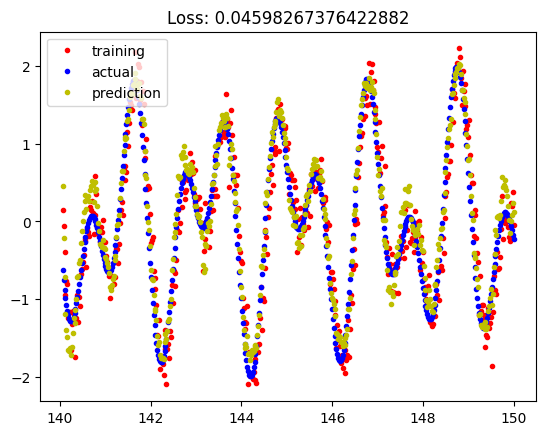

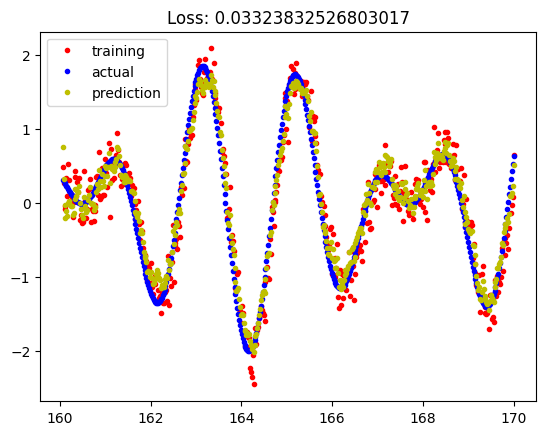

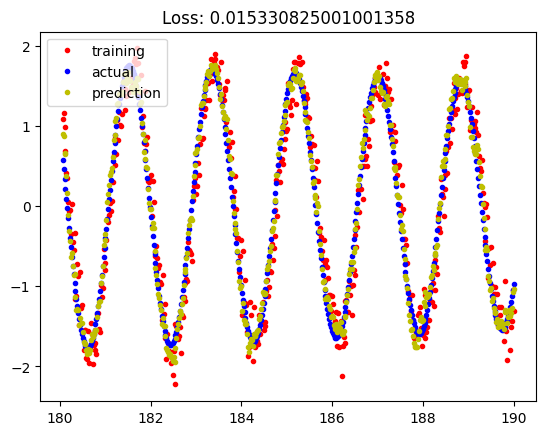

In [10]:

# train the rnn and monitor results

n_steps = 200
stride = 10
lag = 3
alpha = 0.2
seq_length = 500
print_every = 20

trained_rnn = train(rnn, y_func,  n_steps, print_every,
                    stride,seq_length,alpha,lag)

P3Q3: (10pts)

(a) Do you think our model performs well?     
(b) Write about the relationships and interplay between the different hyper-parameters, and explain how they effect the RNN model. Please relate also to the RNN architecture in our solution.

(c) Can you give a real world example where this type of model can be applied?   
(d) What would you change to improve it?

Write your solution here!

a. Yes, the model performs well. Initially, the predicted values are far from both the training data and the true target signal, indicating that the model has not yet learned the underlying temporal structure. As training progresses, the predictions gradually align with the true signal, and the loss decreases significantly.

Despite the training data being corrupted with noise, the model is able to ignore the noise and learn the underlying periodic pattern. This shows that the RNN successfully captures the temporal dependencies in the data and generalizes well to the clean target signal.

b. The model’s performance is strongly influenced by the interaction between its hyperparameters. The sequence length determines how much temporal context the RNN can use: longer sequences allow the model to capture periodic structure and smooth out noise, but they also make training harder due to vanishing or exploding gradients. The lag controls how far into the future the model must predict, with larger lags requiring stronger temporal memory. The hidden dimension and number of layers define the model’s capacity; increasing them allows the network to learn more complex temporal patterns, but also raises the risk of overfitting and instability. The noise level directly affects the difficulty of the task, as higher noise forces the model to rely more on temporal averaging rather than pointwise prediction. Together, these hyperparameters interact with the RNN architecture to balance expressiveness, stability, and generalization.

c. This type of model is well suited for temporal medical measurements, such as monitoring fetal development over time (e.g., organ length, head circumference, or growth curves measured across pregnancy).

The reason this model is appropriate is that: The data are sequential and time-dependent, measurements are often noisy

Future values depend on past trends, not just the current measurement

An RNN can learn the normal developmental trajectory and use past measurements to:

1. predict expected values at later stages

2. identify deviations that may indicate abnormalities

Such deviations could support early diagnosis or intervention.

In fact, as part of a lab course for my undergraduate degree, we worked on this type of data and tried to solve the problem using splines.

d. To improve this model, I would first replace to LSTM since this architecture is better at capturing context and are more robust to vanishing or exploding gradients. This is important in our setting, where the sequence length is long and the underlying signal exhibits periodic behavior with slow drift.

In addition, I would experiment with different sequence lengths and lag values to better balance short term accuracy and long term context. Finally, increasing model depth or hidden dimension, could allow the network to learn richer temporal representations and improve prediction quality.



THE END!